# Estimaciones de cierre
Se estima cierre de 2019 de:
- Ingresos tributarios sin ieps gasolina
- ISR
- IVA
- IEPS sin gasolina
- Impuesto a las importaciones

Se usan modelos seleccionados en Pipeline_analyze, resultado de las estimaciones hechas en Pipeline_multivariate_predict

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Importamos librerias externas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pylab import rcParams
from sklearn.model_selection import ParameterGrid
import itertools
import warnings
import seaborn as sns
from dateutil.relativedelta import relativedelta
import time



# Importamos scripts propios
import download
import descriptive
import models_multivariate as mv
import grid

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings("ignore")

## Importamos datos

In [3]:
# Importamos csv con ingresos netos
ingresos_netos = download.load_ingresos_fiscales_netos()

# Balanza comercial
importaciones = download.load_balanza_comercial('importaciones')
exportaciones=download.load_balanza_comercial('exportaciones')

# Indicadores
igae = download.load_inegi_indic('igae')
igae_sa = download.load_inegi_indic('igae_sa')
igae_prim=download.load_inegi_indic('igae_prim')
igae_secun=download.load_inegi_indic('igae_secun')
igae_terc=download.load_inegi_indic('igae_terc')
indic_mens_consumo = download.load_inegi_indic('indic_mens_consumo')
confianza_consumidor=download.load_inegi_indic('confianza_consumidor')
indic_mens_consumo=download.load_inegi_indic('indic_mens_consumo')
indic_adelant=download.load_inegi_indic('indic_adelant')

# Imai
imai = download.load_inegi_indic('imai')
imai_mineria=download.load_inegi_indic('imai_mineria')
imai_construccion=download.load_inegi_indic('imai_construccion')
imai_manufacturas=download.load_inegi_indic('imai_manufacturas')
imai_egergia_gas_agua_gas=download.load_inegi_indic('imai_egergia_gas_agua_gas')


# Ocupación
asegurados_imss = download.load_inegi_indic('asegurados_imss')
pea=download.load_inegi_indic('pea')
pobl_ocupada=download.load_inegi_indic('pobl_ocupada')

# Tipo de cambio
tc_mensual = download.load_banxico('tc_mensual')
trade_weighted_exchange_rate = download.load_banxico('trade_weighted_exchange_rate')

# Tasas de interés
tasa_cetes_91_mensual = download.load_banxico('tasa_cetes_91_mensual')
tbill_3meses_mensual = download.load_fed('tbill_3meses_mensual')

# Precios
cons_price_index_us = download.load_fed('cons_price_index_us')
inpc = download.load_inpc()
commodity_price_index = download.load_fed('commodity_price_index')

# Indicadores US
ind_prod_ind_us = download.load_fed('ind_prod_ind_us')

# Semana santa
semana_santa = pd.read_excel('../inputs/semana_santa.xlsx', index_col='fecha')
semana_santa['semana_santa'] = 1
semana_santa = semana_santa.reindex(pd.date_range('1990-01-01', '2022-12-01', freq='MS'))
semana_santa = semana_santa.fillna(0)

# Reformas tributarias
tasas_impuestos = pd.read_excel('../inputs/tasas_impuestos.xlsx', index_col='fecha')
tasas_impuestos = tasas_impuestos.diff(12)

# Semana santa fin de marzo
semana_santa_fin_marzo = pd.read_excel('../inputs/semana_santa_fin_mazo.xlsx', index_col='fecha')
semana_santa_fin_marzo['semana_santa'] = 1
semana_santa_fin_marzo = semana_santa.reindex(pd.date_range('1990-01-01', '2022-12-01', freq='MS'))
semana_santa_fin_marzo = semana_santa.reindex(pd.date_range('1990-01-01', '2022-12-01', freq='MS'))

# Construimos df con semana santa y tasas tribtarias
semana_santa_y_tasas = pd.concat([semana_santa_fin_marzo, tasas_impuestos], axis=1)
semana_santa_y_tasas = semana_santa_y_tasas.loc[semana_santa_y_tasas.notna().all(1)]

# Parámetros de las estimaciones
En el siguiente diccionario están los modelos que vamos a estimar para cada una de las variables. Comenzamos por el modelo para estimar las variables de Estados Unidos, después para estimar el Marco Macro mexicano, y depués con los modelos específicos de cada variable tributaria.

In [4]:
params = {
    # Especificamos el primer mes que vamos a predecir
    'begining': '2019-07-01',
    # Especificamos el último mes para el cual tomaremos datos del DF. Esto impactará el número de
    # variables que tenemos que hacer nowcast.
    'last_value_in_df': '2019-06-01',
    # Especificamos los meses que vamos a predecir.
    'periods': 18,
    # Especificamos el modelo para predecir las variables de Estados Unidos
    'us_economy_model':{
        # Tipo de modelo
        'model_name': 'VAR',
        # Variables endógenas
        'endog_vars': ['tbill_3meses_mensual', 'cons_price_index_us',\
                      'ind_prod_ind_us', 'trade_weighted_exchange_rate',
                      'commodity_price_index'],
        # Transformación a aplicar
        'endog_transformation': 'log_diff',
        # Dummies a incluir en las variables exógenas
        'year_dummies': [2000, 2009],
        # Inicio de la estimación del VAR
        'start_var': '1992-01-01',
        # Parámetros que necesitamos especificar en la libreria statsmodels
        'params': {'maxlags': 12, 'ic': 'bic', 'trend': 'c'}},
    # Ahora especificamos los parámetros del VAR de la economía mexicana.
    'mx_economy_model':{
        'model_name': 'VAR',
        'endog_vars': ['igae_sa', 'tc_mensual', 'tasa_cetes_91_mensual', 'inpc',\
                       'ingresos_sector_publico_neto_(mdp)_r', 'importaciones_r', 'indic_mens_consumo'],
        'endog_transformation': 'log_diff',
        'year_dummies': [2009],
        'exog_transformation': 'log_diff',
        'exog_vars': ['commodity_price_index', 'cons_price_index_us', 'ind_prod_ind_us',
                      'tbill_3meses_mensual', 'trade_weighted_exchange_rate'],
        'semana_santa': True,
        'semana_santa_fin_de_marzo_y_tasas': False,
        'params': {'maxlags': 12, 'ic': 'aic', 'trend': 'ct'},
        'start_var': '2000-01-01'},
    # Especificamos los parámetros de los modelos econométricos con solo una variable endeogena:
    'ARIMAS':{
    # Especificamos los parámetros del modelo para predecir ingresos tributarios sin IEPS gasolina
        'ing_trib_neto_(mdp)_r': {
            'model_name': 'SARIMA',
            'endog_vars': ['ing_trib_neto_(mdp)_r'],
            'endog_transformation': 'log_diff',
            'exog_vars': ['igae_sa', 'inpc', 'tasa_cetes_91_mensual',
                          'tc_mensual', 'commodity_price_index', 'importaciones_r'],
            'exog_transformation': 'log_diff',
            'semana_santa': False,
            'semana_santa_fin_de_marzo_y_tasas': True,
            'year_dummies': [2009, 2015],
            'month_dummies': [1, 3, 4, 12],
            'params': {'enforce_invertibility': False, 'enforce_stationarity': False,
                       'order': (2, 0, 3), 'seasonal_order': (1, 0, 1, 12)},
            'start': '1990-01-01'},
        'ing_trib_sin_gasol_neto_(mdp)_r': {
            'model_name': 'SARIMA',
            'endog_vars': ['ing_trib_sin_gasol_neto_(mdp)_r'],
            'endog_transformation': 'log_diff',
            'exog_vars': ['igae_sa', 'inpc', 'tasa_cetes_91_mensual',
                          'tc_mensual', 'commodity_price_index', 'importaciones_r'],
            'exog_transformation': 'log_diff',
            'semana_santa': False,
            'semana_santa_fin_de_marzo_y_tasas': True,
            'year_dummies': [2009, 2015],
            'month_dummies': [1, 3, 4, 12],
            'params': {'enforce_invertibility': False, 'enforce_stationarity': False,
                       'order': (3, 0, 3), 'seasonal_order': (1, 0, 1, 12)},
            'start': '1990-01-01'},
        # Especificamos los parámetros del modelo para predecir ingresos por ISR
        'isr_neto_(mdp)_r': {
            'model_name': 'SARIMA',
            'endog_vars': ['isr_neto_(mdp)_r'],
            'endog_transformation': 'log_diff',
            'exog_vars': ['igae_sa', 'inpc', 'tasa_cetes_91_mensual', 'tc_mensual',
                          'commodity_price_index', 'importaciones_r', 'indic_mens_consumo'],
            'exog_transformation': 'log_diff',
            'semana_santa': False,
            'semana_santa_fin_de_marzo_y_tasas': True,
            'year_dummies': [2009, 2015],
            'month_dummies': [1, 3, 4, 12],
            'params': {'enforce_invertibility': False, 'enforce_stationarity': False,
                          'order': (2, 0, 3), 'seasonal_order': (1, 0, 1, 12)},
            'start': '1990-01-01'},
        # Especificamos los parámetros del modelo para predecir ingresos por IVA
        'iva_neto_(mdp)_r': {
            'model_name': 'SARIMA',
            'endog_vars': ['iva_neto_(mdp)_r'],
            'endog_transformation': 'log_diff',
            'exog_vars': ['igae_sa', 'inpc', 'tasa_cetes_91_mensual', 'tc_mensual',
                          'commodity_price_index', 'importaciones_r', 'indic_mens_consumo'],
            'exog_transformation': 'log_diff',
            'semana_santa': False,
            'semana_santa_fin_de_marzo_y_tasas': True,
            'year_dummies': [2009, 2015],
            'month_dummies': [1, 3, 4, 12],
            'params': {'enforce_invertibility': False, 'enforce_stationarity': False,
                       'order': (3, 0, 2), 'seasonal_order': (1, 0, 0, 12)},
            'start': '1990-01-01'},
#         Especificamos los parámetros del modelo para predecir ingresos por Impuesto a las importaciones
        'importaciones_neto_(mdp)_r': {
            'model_name': 'SARIMA',
            'endog_vars': ['importaciones_neto_(mdp)_r'],
            'endog_transformation': 'log_diff',
            'exog_vars': ['igae_sa', 'inpc', 'tasa_cetes_91_mensual', 'tc_mensual',
                          'commodity_price_index', 'importaciones_r', 'indic_mens_consumo'],
            'exog_transformation': 'log_diff',
            'semana_santa': False,
            'semana_santa_fin_de_marzo_y_tasas': True,
            'year_dummies': [2009, 2015],
            'month_dummies': [1, 3, 4, 12],
            'params': {'enforce_invertibility': False, 'enforce_stationarity': False,
                       'order': (3, 0, 3), 'seasonal_order': (1, 0, 1, 12)},
            'start': '1990-01-01'},
        # Especificamos los parámetros del modelo para predecir ingresos por IEPS sin contar gasolinas
        'ieps_sin_gas_neto_(mdp)_r':{
            'model_name': 'ARIMA',
            'endog_vars': ['ieps_sin_gas_neto_(mdp)_r'],
            'endog_transformation': 'log_diff',
            'exog_vars': ['igae_sa', 'inpc', 'tasa_cetes_91_mensual', 'tc_mensual',
                          'commodity_price_index', 'importaciones_r', 'indic_mens_consumo'],
            'exog_transformation': 'log_diff',
            'semana_santa': False,
            'semana_santa_fin_de_marzo_y_tasas': True,
            'year_dummies': [2009, 2015],
            'month_dummies': [1, 3, 4, 12],
            'params': {'order': (5, 0, 1)},
            'start': '1990-01-01'}},
    # Especificamos los parámetros del VAR de ingresos tributarios que estimaremos además de los anteriores
    'var_ingresos_tributarios_ieps':{
        'model_name': 'VAR',
        'endog_vars': ['isr_neto_(mdp)_r', 'iva_neto_(mdp)_r', 'importaciones_neto_(mdp)_r',
                       'ieps_sin_gas_neto_(mdp)_r', ],
        'endog_transformation': 'log_diff',
        'year_dummies': [2009, 2015],
        'exog_transformation': 'log_diff',
        'exog_vars': ['igae_sa', 'inpc', 'tasa_cetes_91_mensual',\
                      'tc_mensual', 'commodity_price_index', 'importaciones_r', 'indic_mens_consumo'],
        'semana_santa': False,
        'semana_santa_fin_de_marzo_y_tasas': True,
        'exog_transformation': 'log_diff',
        'month_dummies': [1, 3, 4, 12],
        'params': {'maxlags': 12, 'ic': 'aic', 'trend': 'ct'},
        'start_var': '2000-01-01'},
    'var_ingresos_tributarios_isr':{
        'model_name': 'VAR',
        'endog_vars': ['isr_neto_(mdp)_r', 'importaciones_neto_(mdp)_r'],
        'endog_transformation': 'log_diff',
        'year_dummies': [2009, 2015],
        'exog_transformation': 'log_diff',
        'exog_vars': ['igae_sa', 'inpc', 'tasa_cetes_91_mensual',\
                      'tc_mensual', 'commodity_price_index', 'importaciones_r', 'indic_mens_consumo'],
        'semana_santa': False,
        'semana_santa_fin_de_marzo_y_tasas': True,
        'exog_transformation': 'log_diff',
        'month_dummies': [1, 3, 4, 12],
        'params': {'maxlags': 12, 'ic': 'aic', 'trend': 'ct'},
        'start_var': '2000-01-01'},
    # Especificamos los parámetros de los modelos de Machine Learning:
    'ml_models':{
        'importaciones_neto_(mdp)_r': {
            'model_name': 'GB',
            'endog_vars': ['importaciones_neto_(mdp)_r'],
            'endog_transformation': 'log_diff',
            'endog_lags': range(1, 13),
            'year_dummies': True,
            'exog_transformation': 'log_diff',
            'exog_pct_changes': [1, 12],
            'exog_lags': range(1, 13),
            'month_dummies': True,
            'start': '1990-01-01',
            'semana_santa_fin_de_marzo_y_tasas': True,
            'params': {'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 50,
                       'random_state': 1234, 'subsample': 1.0}},
        'iva_neto_(mdp)_r': {
            'model_name': 'RF',
            'endog_vars': ['iva_neto_(mdp)_r'],
            'endog_transformation': 'log_diff',
            'endog_lags': range(1, 13),
            'year_dummies': True,
            'exog_transformation': 'log_diff',
            'exog_pct_changes': [1, 12],
            'exog_lags': range(1, 13),
            'month_dummies': True,
            'start': '1990-01-01',
            'semana_santa_fin_de_marzo_y_tasas': True,
            'params': {'criterion': 'mae', 'max_depth': 50, 'max_features': 'sqrt',
                       'min_samples_split': 10, 'n_estimators': 1000, 'n_jobs': -1,
                       'random_state': 1234}}
    }
}

In [5]:
# Nos quedamos unicamente ingresos reales
ingresos_reales = ['ieps_neto_(mdp)_r', 'ieps_sin_gas_neto_(mdp)_r', 'ingresos_sector_publico_neto_(mdp)_r',
                   'ing_gob_fed_neto_(mdp)_r', 'ing_trib_neto_(mdp)_r', 'isr_neto_(mdp)_r',
                   'iva_neto_(mdp)_r', 'importaciones_neto_(mdp)_r', 'ing_trib_sin_gasol_neto_(mdp)_r']

ingresos_netos_reales = ingresos_netos[ingresos_reales]

In [6]:
# Diccionario para agregaciones anuales
aggregation_dict = {    
'igae_sa': 'mean',
'igae': 'mean',
'inpc': 'mean',
'tasa_cetes_91_mensual': 'mean',
'tc_mensual': 'mean', 
'ieps_neto_(mdp)_r': 'sum',
'ieps_sin_gas_neto_(mdp)_r': 'sum',
'ing_gob_fed_neto_(mdp)_r': 'sum',
'ing_trib_neto_(mdp)_r': 'sum',
'isr_neto_(mdp)_r': 'sum',
'iva_neto_(mdp)_r': 'sum',
'importaciones_neto_(mdp)_r': 'sum',
'ing_trib_sin_gasol_neto_(mdp)_r': 'sum',
'ing_trib_neto_(mdp)_r': 'sum',
'ingresos_sector_publico_neto_(mdp)_r': 'sum',
'tc_mensual': 'mean',
'tasa_cetes_91_mensual': 'mean',
'imai': 'mean',
'inpc': 'mean',
'tbill_3meses_mensual': 'mean',
'cons_price_index_us': 'mean',
'ind_prod_ind_us': 'mean',
'trade_weighted_exchange_rate': 'mean',
'commodity_price_index': 'mean',
'importaciones': 'sum',
'importaciones_r': 'sum',
'indic_mens_consumo': 'mean'}

## Construimos DF conjunto
Para aprovechar los datos que han salido, tendremos que predecir algunas variables para uno o dos meses. Queremos un DF completo hasta Junio, pero el commodity price index solo lo tenemos hasta Mayo, al igual que el IGAE, el IMAI y el indicador mensual de consumo. 

Comenzaremos por formar un DF de variables externas, que denominamos df_netos_us por la mayoría ser de Estados Unidos, y predecir el commodity price index. Después, formamos un df conjunto entre las variables mexicanas y las variables externas y predecimos las variables mexicanas.

In [7]:
# Primero construniso DF de USA
df_netos_us = pd.concat([tbill_3meses_mensual, cons_price_index_us, ind_prod_ind_us, trade_weighted_exchange_rate,
                         commodity_price_index],
                        axis=1)
# Especificamos que el DF es de frecuencia mensual
df_netos_us = df_netos_us.asfreq('MS')
# Nos quedamos con los valores después de 1992 y antes de Junio de 2016. Usamos los parámetros que especificamos. 
df_netos_us = df_netos_us.loc[params['us_economy_model']['start_var']: params['last_value_in_df']]

In [8]:
# Vamos cuales son las variables que tenemos que hacer nowcast. Obtenemos aquellas que valen NA para las
# últimas fechas. Creamos una lista con ellas que se llama vars_to_predict_us
vars_to_predict_us = df_netos_us.columns[df_netos_us.tail().isna().any()]
# Para cada una de esas variables obtendremos una predicción con un modelo SARIMA. Únicamente estamos prediciendo
# un valor para tener todo el DF actualizado a junio, y la selección del modelo SARIMA se hizo por ser el
# modelo que mejor funcionó con los ingresos tributarios. 
for var in vars_to_predict_us:
    # Cada que volvemos a empezar, volvemos a obtener variables que tienen valores nulos, 
    # pues en cada loop predecimos una variable. Creamos una lista local empty_vars
    empty_vars = df_netos_us.columns[df_netos_us.tail().isna().any()]
    # Usaremos como variables exógenas a todas las variables que están en el DF de USA que NO están en empty vars/
    us_vars_to_use_as_covars = [var for var in df_netos_us.columns if var not in empty_vars]
    # Creamos un DF de variables exeogenas usando esas variables
    exog = df_netos_us[us_vars_to_use_as_covars].copy()
    # Ampliamos nuestro DF de variables exeogenas usando la función construct_exog del script models_multivariate
    # especificamos que queremos dummies para todos los meses y dummies para el 2000 y el 2009.
    exog = mv.construct_exog(exog, month_dummies=False, year_dummies=[2000, 2009])
    # Obtenemos el primer mes que tenemos que predecir al obtener el índice del último valor válido de
    # la variable en curso en el loop.
    prediction_start = df_netos_us.loc[df_netos_us[var].notna()].index.max() + relativedelta(months=1)
    # Corremos la función predict_with_econometric_model del script models multivariate que toma diferentes
    # argumentos y retorna dos predicciones: La de la variable transformada, y la variable original. Unicamente
    # queremos la de la variable original por lo que el primer argumento lo asignamos a _
    _, prediction = mv.predict_with_econometric_model(
        # Especificamos que el modelo será un SARIMA
        model_name='SARIMA',
        # Especifiamos los parámetros
        params={'order': (3, 0, 3), 'seasonal_order': (1, 0, 1, 12)},
        # Especificamos el DataFrame del cual se obtendrán la variable endógena. 
        df=df_netos_us,
        # Especificamos las variables endógenas (Deben ir en lista aunque sea una sola)
        endog_vars=[var],
        # Especificamos el inicio de la predicción
        prediction_start=prediction_start,
        # Especificamos el final de la predicción usando la fecha máxima del DF.
        prediction_end=df_netos_us.index.max(),
        # Especificamos la transformación de la variable endógena
        transformation='log_diff',
        # Especificamos que no queremos ningun LAG en las variables exógenas
        lags_endog=None,
        # Especificamos el DF de variables exógenas
        exog_df=exog,
        # Especificamos que queremos que tome todo el DF para estimar el modelo
        train_start=None)
    # Asignamos la predicción al df de variables de USA
    df_netos_us.loc[pd.date_range(prediction_start, df_netos_us.index.max(), freq='MS'), var] = prediction
    # Imprimimos notificación y volvemos a empezar.
    print('Nowcasted {}'.format(var))

Nowcasted commodity_price_index


In [9]:
# Ahora construimos DF . Concatenamos el DF de USA con las variables mexicanas que queremos
df_netos = pd.concat([ingresos_netos_reales, igae_sa, tc_mensual, tasa_cetes_91_mensual,
                      imai, inpc, df_netos_us, importaciones, indic_mens_consumo], axis=1)
# Especificamos que es un DF mensual
df_netos = df_netos.asfreq('MS')
# Filtramos df para post 1993.
df_netos = df_netos.loc['1993-01-01':'2019-06-01']

In [10]:
# Vamos cuales son las variables que tenemos que hacer nowcast, al igual que con el DF de USA. Creamos lista de
# variables a predecir
vars_to_predict = df_netos.columns[df_netos.tail().isna().any()]
vars_to_predict

Index(['igae_sa', 'indic_mens_consumo'], dtype='object')

In [11]:
# Haremos un loop sobre cada una de las variables a predecir
for var in vars_to_predict:
    # Cada que volvemos a empezar, volvemos a obtener variables que tienen valores nulos, 
    # pues en cada loop predecimos una variable. Creamos una lista local empty_vars
    empty_vars = df_netos.columns[df_netos.tail().isna().any()]
    # Usaremos como variables exógenas a todas las variables que están en el DF de USA que NO están en empty vars/
    potential_covars = ['igae_sa', 'inpc', 'tasa_cetes_91_mensual', 'tc_mensual',
                        'importaciones_r', 'indic_mens_consumo']\
                        + [col for col in df_netos_us.columns]
    vars_to_use_as_covars = [var for var in potential_covars if var not in empty_vars]
    print(vars_to_use_as_covars)
    # Creamos un DF de variables exeogenas usando esas variables
    exog = df_netos[vars_to_use_as_covars].copy()
    # Ampliamos nuestro DF de variables exeogenas usando la función construct_exog del script models_multivariate
    # especificamos que queremos dummies para todos los meses y dummies para el 2000 y el 2009.
    exog = mv.construct_exog(exog, month_dummies=False, year_dummies=[2000, 2009])
    # Obtenemos el primer mes que tenemos que predecir al obtener el índice del último valor válido de
    # la variable en curso en el loop.
    prediction_start = df_netos.loc[df_netos[var].notna()].index.max() + relativedelta(months=1)
    # Corremos la función predict_with_econometric_model del script models multivariate que toma diferentes
    # argumentos y retorna dos predicciones: La de la variable transformada, y la variable original. Unicamente
    # queremos la de la variable original por lo que el primer argumento lo asignamos a _
    _, prediction = mv.predict_with_econometric_model(
        # Especificamos que el modelo será un SARIMA
        model_name='SARIMA',
        # Especifiamos los parámetros
        params={'order': (3, 0, 3), 'seasonal_order': (1, 0, 1, 12),
                'enforce_stationarity': False, 'enforce_invertibility': False},
        # Especificamos el DataFrame del cual se obtendrán la variable endógena. 
        df=df_netos,
        # Especificamos las variables endógenas (Deben ir en lista aunque sea una sola)
        endog_vars=[var],
        # Especificamos el inicio de la predicción
        prediction_start=prediction_start,
        # Especificamos el final de la predicción usando la fecha máxima del DF.
        prediction_end=df_netos.index.max(),
        # Especificamos la transformación de la variable endógena
        transformation='log_diff',
        # Especificamos que no queremos ningun LAG en las variables exógenas
        lags_endog=None,
        # Especificamos el DF de variables exógenas
        exog_df=exog,
        # Especificamos que queremos que tome todo el DF para estimar el modelo
        train_start=None)
    # Asignamos la predicción al df de variables
    df_netos.loc[pd.date_range(prediction_start, df_netos.index.max(), freq='MS'), var] = prediction
    # Imprimimos notificación y volvemos a empezar.
    print('Nowcasted {}'.format(var))

['inpc', 'tasa_cetes_91_mensual', 'tc_mensual', 'importaciones_r', 'tbill_3meses_mensual', 'cons_price_index_us', 'ind_prod_ind_us', 'trade_weighted_exchange_rate', 'commodity_price_index']
Nowcasted igae_sa
['igae_sa', 'inpc', 'tasa_cetes_91_mensual', 'tc_mensual', 'importaciones_r', 'tbill_3meses_mensual', 'cons_price_index_us', 'ind_prod_ind_us', 'trade_weighted_exchange_rate', 'commodity_price_index']
Nowcasted indic_mens_consumo


# Predicción del Marco Marcro de Estados Unidos.

In [12]:
# Estimamos modelo VAR de Estados Unidos para predecir el cierre de 2019 y el 2020.
# Convertimos fecha inicial a datetime
start = pd.to_datetime(params['begining'])
# Obtenemos fecha final usando relativedelta que sirve para sumar fechas. Restamos 1 al número de periodos
# porque a Julio hay que sumarle solo 17 para llegar a Diciembre del siguiente año.
end = start + relativedelta(months=params['periods'] - 1)
# Creamos el índice del DF exógeno que es una fecha desde el inicio del DF endógeno hasta el final de
# la predicción
date_range_of_exog = pd.date_range(params['us_economy_model']['start_var'], end, freq='MS')
# Creamos el DF exógeno
exog = pd.DataFrame(index=date_range_of_exog)
# Ampliamos el DF exeogeno usando la funcieon construct exog
exog = mv.construct_exog(exog_base=exog,
                         year_dummies=params['us_economy_model']['year_dummies'])
# Obtenemos predicción usando función predict_with_econometric_model de models_multivariate
_, prediction_us = mv.predict_with_econometric_model(
    model_name=params['us_economy_model']['model_name'], 
    params=params['us_economy_model']['params'],
    df=df_netos_us,
    endog_vars=params['us_economy_model']['endog_vars'],
    prediction_start=start,
    prediction_end=end,
    transformation=params['us_economy_model']['endog_transformation'],
    lags_endog=None,
    exog_df=None,
    train_start=params['us_economy_model']['start_var'],
    freq='MS')
# Concatenamos la predicción y el DF de USA para tener todos los datos
prediction_us = pd.concat([df_netos_us, prediction_us], sort=True)

LAGS_USED 1


In [13]:
prediction_us

,commodity_price_index,cons_price_index_us,ind_prod_ind_us,tbill_3meses_mensual,trade_weighted_exchange_rate
1992-01-01,50.724146,138.100000,62.993600,3.800000,74.408200
1992-02-01,50.722601,138.600000,63.886000,3.840000,75.643500
1992-03-01,50.748701,139.300000,64.567600,4.040000,77.336800
1992-04-01,51.174700,139.500000,63.875100,3.750000,77.424200
1992-05-01,52.635726,139.700000,64.389600,3.630000,77.086600
1992-06-01,52.852571,140.200000,66.167600,3.660000,76.244300
1992-07-01,52.518993,140.500000,64.115000,3.210000,75.302500
1992-08-01,52.580209,140.900000,66.174500,3.130000,75.118300
1992-09-01,53.009000,141.300000,66.368000,2.910000,75.873100
1992-10-01,52.500685,141.800000,66.665200,2.860000,77.527100


# Predicción del Marco Macro de México

In [14]:
# Estimamos modelo VAR de Meexico para predecir el cierre de 2019 y el 2020.
# Convertimos fecha inicial a datetime
start = pd.to_datetime(params['begining'])
# Obtenemos fecha final usando relativedelta que sirve para sumar fechas. Restamos 1 al número de periodos
# porque a Julio hay que sumarle solo 17 para llegar a Diciembre del siguiente año.
end = start + relativedelta(months=params['periods'] - 1)
# Creamos el índice del DF exógeno que es una fecha desde el inicio del DF endógeno hasta el final de
# la predicción
date_range_of_exog = pd.date_range(params['mx_economy_model']['start_var'], end, freq='MS')
# Creamos el DF exógeno que se basará en la predicción del Marco Macro de Estados Unidos
exog = pd.DataFrame(index=date_range_of_exog)
# Concatenamos la predicción de Estaods Unidos, quedandonos solo con las variables que especificamos
exog = exog.merge(prediction_us[params['mx_economy_model']['exog_vars']], left_index=True, right_index=True)
# Ampliamos el DF exeogeno usando la función construct exog
exog = mv.construct_exog(exog_base=exog,
                         transformation=params['mx_economy_model']['exog_transformation'],
                         year_dummies=params['mx_economy_model']['year_dummies'])
# Añadimos semana santa
if params['mx_economy_model']['semana_santa']:
    exog = exog.merge(semana_santa, left_index=True, right_index=True)
# Obtenemos predicción usando función predict_with_econometric_model de models_multivariate
_, prediction_mx = mv.predict_with_econometric_model(
    model_name=params['mx_economy_model']['model_name'], 
    params=params['mx_economy_model']['params'],
    df=df_netos,
    endog_vars=params['mx_economy_model']['endog_vars'],
    prediction_start=start,
    prediction_end=end,
    transformation=params['mx_economy_model']['endog_transformation'],
    lags_endog=None,
    exog_df=exog,
    train_start=params['mx_economy_model']['start_var'],
    freq='MS')
# Concatenamos la predicción y el DF de observados para tener todos los datos
prediction_mx = pd.concat([df_netos[params['mx_economy_model']['endog_vars']], prediction_mx], sort=True)

LAGS_USED 12


In [15]:
# Creamos diccionario de agregacion solo para MX
mx_aggregation_dict = {k: v for k, v in aggregation_dict.items() if k in prediction_mx}
# Creamos diccionario vacio donde colocaremos predicciones anuales de MX
yearly_prediction_mx = prediction_mx.resample('YS').aggregate(mx_aggregation_dict)

In [16]:
yearly_prediction_mx.pct_change()

,igae_sa,inpc,tasa_cetes_91_mensual,tc_mensual,ingresos_sector_publico_neto_(mdp)_r,importaciones_r,indic_mens_consumo
1993-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-01,0.049083,0.069658,-0.056992,0.083423,0.051767,0.231337,0.055267
1995-01-01,-0.062248,0.349993,2.300815,0.901863,-0.052876,0.292202,-0.047989
1996-01-01,0.066073,0.343784,-0.317914,0.184033,0.026210,0.081170,0.043992
1997-01-01,0.069029,0.206256,-0.353981,0.042040,0.054931,0.059208,0.074625
1998-01-01,0.052018,0.159284,0.231635,0.155403,-0.080571,0.140413,0.062972
1999-01-01,0.026880,0.165856,-0.145390,0.044485,0.047064,0.010648,0.045875
2000-01-01,0.050814,0.094916,-0.278053,-0.010567,0.128678,0.113163,0.068666
2001-01-01,-0.004973,0.063677,-0.242249,-0.012438,0.014193,-0.102783,0.023747
2002-01-01,-0.001105,0.050307,-0.392266,0.034979,0.037850,-0.012401,0.016260


# Predicciones de Ingresos Tributarios
 - Comenzamos con ingresos tributarios, desués ISR, IVA, Importaciones e IEPS. Hacemos loop

In [17]:
params_arima = params['ARIMAS']

In [18]:
predictions_date_range = pd.date_range(df_netos.index.min(), end, freq='MS')
predictions_arima_ing_trib = pd.DataFrame(index=predictions_date_range)
for var_trib in ['ing_trib_neto_(mdp)_r', 'ing_trib_sin_gasol_neto_(mdp)_r', 'isr_neto_(mdp)_r',
                 'iva_neto_(mdp)_r', 'ieps_sin_gas_neto_(mdp)_r']:
    # Estimamos modelos de ingresos tributarios para predecir el cierre de 2019 y el 2020.
    # Convertimos fecha inicial a datetime
    start = pd.to_datetime(params['begining'])
    # Obtenemos fecha final usando relativedelta que sirve para sumar fechas. Restamos 1 al número de periodos
    # porque a Julio hay que sumarle solo 17 para llegar a Diciembre del siguiente año.
    end = start + relativedelta(months=params['periods'] - 1)
    # Creamos el índice del DF exógeno que es una fecha desde el inicio del DF endógeno hasta el final de
    # la predicción
    date_range_of_exog = pd.date_range(params_arima[var_trib]['start'], end, freq='MS')
    # Creamos el DF exógeno que se basará en la predicción del Marco Macro de Estados Unidos
    exog = pd.DataFrame(index=date_range_of_exog)
    # Hacemos merge de variables de USA y de variables de Meexico
    us_mex = pd.merge(prediction_us, prediction_mx, left_index=True, right_index=True)
    # Concatenamos la predicción de Estaods Unidos y México, quedándonos solo con las variables que especificamos
    exog = exog.merge(us_mex[params_arima[var_trib]['exog_vars']],
                      left_index=True, right_index=True)
    # Ampliamos el DF exeogeno usando la función construct exog
    exog = mv.construct_exog(exog_base=exog,
                             month_dummies=params_arima[var_trib]['month_dummies'],
                             transformation=params_arima[var_trib]['exog_transformation'],
                             year_dummies=params_arima[var_trib]['year_dummies'])
    # Añadimos semana santa fin de marzo y tassas
    if params_arima[var_trib]['semana_santa_fin_de_marzo_y_tasas']:
        exog = exog.merge(semana_santa_y_tasas, left_index=True, right_index=True)
    # Obtenemos predicción usando función predict_with_econometric_model de models_multivariate
    _, prediction_arima_trib = mv.predict_with_econometric_model(
        model_name=params_arima[var_trib]['model_name'], 
        params=params_arima[var_trib]['params'],
        df=df_netos,
        endog_vars=params_arima[var_trib]['endog_vars'],
        prediction_start=start,
        prediction_end=end,
        transformation=params_arima[var_trib]['endog_transformation'],
        lags_endog=None,
        exog_df=exog,
        train_start=params_arima[var_trib]['start'],
        freq='MS')
    # Concatenamos la predicción y el DF de observados para tener todos los datos
    prediction_arima_trib = prediction_arima_trib.rename(var_trib).to_frame()
    prediction_arima_trib = pd.concat([df_netos[[var_trib]], prediction_arima_trib], sort=True)
    predictions_arima_ing_trib = predictions_arima_ing_trib.merge(
        prediction_arima_trib, left_index=True, right_index=True)

# Estimamos VAR

In [19]:
predictions_with_var = {}
for model in ['var_ingresos_tributarios_ieps', 'var_ingresos_tributarios_isr']:
    # Estimamos modelos de ingresos tributarios para predecir el cierre de 2019 y el 2020.
    # Convertimos fecha inicial a datetime
    start = pd.to_datetime(params['begining'])
    # Obtenemos fecha final usando relativedelta que sirve para sumar fechas. Restamos 1 al número de periodos
    # porque a Julio hay que sumarle solo 17 para llegar a Diciembre del siguiente año.
    end = start + relativedelta(months=params['periods'] - 1)
    # Creamos el índice del DF exógeno que es una fecha desde el inicio del DF endógeno hasta el final de
    # la predicción
    date_range_of_exog = pd.date_range(params[model]['start_var'], end, freq='MS')
    # Creamos el DF exógeno que se basará en la predicción del Marco Macro de Estados Unidos
    exog = pd.DataFrame(index=date_range_of_exog)
    # Hacemos merge de variables de USA y de variables de Meexico
    us_mex = pd.merge(prediction_us, prediction_mx, left_index=True, right_index=True)
    # Concatenamos la predicción de Estaods Unidos y México, quedándonos solo con las variables que especificamos
    exog = exog.merge(us_mex[params[model]['exog_vars']],
                      left_index=True, right_index=True)
    # Ampliamos el DF exeogeno usando la función construct exog
    exog = mv.construct_exog(exog_base=exog,
                             month_dummies=params[model]['month_dummies'],
                             transformation=params[model]['exog_transformation'],
                             year_dummies=params[model]['year_dummies'])
    # Añadimos semana santa fin de marzo y tassas
    if params[model]['semana_santa_fin_de_marzo_y_tasas']:
        exog = exog.merge(semana_santa_y_tasas, left_index=True, right_index=True)
    # Obtenemos predicción usando función predict_with_econometric_model de models_multivariate
    _, predictions_var_trib = mv.predict_with_econometric_model(
        model_name=params[model]['model_name'], 
        params=params[model]['params'],
        df=df_netos,
        endog_vars=params[model]['endog_vars'],
        prediction_start=start,
        prediction_end=end,
        transformation=params[model]['endog_transformation'],
        lags_endog=None,
        exog_df=exog,
        train_start=params[model]['start_var'],
        freq='MS')
    # Concatenamos la predicción y el DF de observados para tener todos los datos

    predictions_var_trib = pd.concat([df_netos[params[model]['endog_vars']], predictions_var_trib],
                                    sort=True)
    predictions_with_var[model] = predictions_var_trib

LAGS_USED 11
LAGS_USED 12


# Estimamos modelos de ML

In [20]:
predictions_date_range = pd.date_range(df_netos.index.min(), end, freq='MS')
predictions_ml_ing_trib = pd.DataFrame(index=predictions_date_range)
params_ml = params['ml_models']
# Estimamos modelos de ingresos tributarios para predecir el cierre de 2019 y el 2020.
# Convertimos fecha inicial a datetime
start = pd.to_datetime(params['begining'])
# Obtenemos fecha final usando relativedelta que sirve para sumar fechas. Restamos 1 al número de periodos
# porque a Julio hay que sumarle solo 17 para llegar a Diciembre del siguiente año.
end = start + relativedelta(months=params['periods'] - 1)
# Creamos el índice del DF exógeno que es una fecha desde el inicio del DF endógeno hasta el final de
# la predicción
for var, model_dict in params_ml.items():
    print(var)
    date_range_of_exog = pd.date_range(model_dict['start'], end, freq='MS')
    # Creamos el DF exógeno que se basará en la predicción del Marco Macro de Estados Unidos
    exog = pd.DataFrame(index=date_range_of_exog)
    # Hacemos merge de variables de USA y de variables de Meexico
    us_mex = pd.merge(prediction_us, prediction_mx, left_index=True, right_index=True)
    # Concatenamos la predicción de Estaods Unidos y México, quedándonos solo con las variables que especificamos
    exog = exog.merge(us_mex, left_index=True, right_index=True)
    # Ampliamos el DF exeogeno usando la función construct exog
    exog = mv.construct_exog(exog_base=exog,
                             transformation=model_dict['exog_transformation'],
                             pct_changes=model_dict['exog_pct_changes'],
                             month_dummies=model_dict['month_dummies'],
                             year_dummies=model_dict['year_dummies'],
                             lags=model_dict['exog_lags'])

    # Añadimos semana santa fin de marzo y tassas
    if model_dict['semana_santa_fin_de_marzo_y_tasas']:
        exog = exog.merge(semana_santa_y_tasas, left_index=True, right_index=True)
    # Obtenemos predicción usando función predict_with_econometric_model de models_multivariate
    _, prediction_ml = mv.predict_with_ml_model(
        model_name=model_dict['model_name'], 
        params=model_dict['params'],
        df=df_netos,
        endog_vars=model_dict['endog_vars'],
        prediction_start=start,
        prediction_end=end,
        transformation=model_dict['endog_transformation'],
        lags_endog=model_dict['endog_lags'],
        exog_df=exog,
        train_start=model_dict['start'],
        freq='MS')
    # Concatenamos la predicción y el DF de observados para tener todos los datos

    prediction_ml = pd.concat([df_netos[model_dict['endog_vars']],
                               prediction_ml],
                               sort=True)
    predictions_ml_ing_trib = predictions_ml_ing_trib.merge(prediction_ml, left_index=True, right_index=True)

importaciones_neto_(mdp)_r
iva_neto_(mdp)_r


# Veamos estimaciones de cierre

In [21]:
prediction_var_ieps = predictions_with_var['var_ingresos_tributarios_ieps'][['ieps_sin_gas_neto_(mdp)_r']]
prediction_var_isr = predictions_with_var['var_ingresos_tributarios_isr'][['isr_neto_(mdp)_r']]

In [22]:
predictions = pd.concat([predictions_ml_ing_trib.add_prefix('ml_'),
                         prediction_var_ieps.add_prefix('var_'),
                         prediction_var_isr.add_prefix('var_'),
                         predictions_arima_ing_trib.add_prefix('arima_')])

In [23]:
predictions.columns

Index(['arima_ieps_sin_gas_neto_(mdp)_r', 'arima_ing_trib_neto_(mdp)_r',
       'arima_ing_trib_sin_gasol_neto_(mdp)_r', 'arima_isr_neto_(mdp)_r',
       'arima_iva_neto_(mdp)_r', 'ml_importaciones_neto_(mdp)_r',
       'ml_iva_neto_(mdp)_r', 'var_ieps_sin_gas_neto_(mdp)_r',
       'var_isr_neto_(mdp)_r'],
      dtype='object')

In [24]:
reorder = [
    'arima_ing_trib_neto_(mdp)_r', 'arima_ing_trib_sin_gasol_neto_(mdp)_r', 'arima_isr_neto_(mdp)_r',
    'var_isr_neto_(mdp)_r', 'arima_iva_neto_(mdp)_r', 'ml_iva_neto_(mdp)_r',
    'ml_importaciones_neto_(mdp)_r',
    'arima_ieps_sin_gas_neto_(mdp)_r', 'var_ieps_sin_gas_neto_(mdp)_r']

In [25]:
predictions = predictions[reorder]

In [26]:
predictions.resample('YS').sum().tail()

,arima_ing_trib_neto_(mdp)_r,arima_ing_trib_sin_gasol_neto_(mdp)_r,arima_isr_neto_(mdp)_r,var_isr_neto_(mdp)_r,arima_iva_neto_(mdp)_r,ml_iva_neto_(mdp)_r,ml_importaciones_neto_(mdp)_r,arima_ieps_sin_gas_neto_(mdp)_r,var_ieps_sin_gas_neto_(mdp)_r
2016-01-01,3.114509e+06,2.796260e+06,1.634997e+06,1.634997e+06,8.850405e+05,885040.493140,57949.111042,153887.384374,153887.384374
2017-01-01,3.083038e+06,2.848792e+06,1.674918e+06,1.674918e+06,8.726363e+05,872636.296416,56578.343710,163742.868998,163742.868998
2018-01-01,3.157853e+06,2.964762e+06,1.716680e+06,1.716680e+06,9.513947e+05,951394.715401,67465.715761,164831.434106,164831.434106
2019-01-01,3.302455e+06,2.999419e+06,1.774792e+06,1.769892e+06,9.587215e+05,950974.127027,60934.354104,158061.819681,151075.395333
2020-01-01,3.551713e+06,3.082254e+06,1.935081e+06,1.890936e+06,1.014161e+06,901117.422907,49720.233426,155959.259177,119087.763983


In [27]:
predictions_ing_trib = predictions[['arima_ing_trib_neto_(mdp)_r']].copy()
predictions_ing_trib['ing_trib_neto_(mdp)_r']=predictions_ing_trib['arima_ing_trib_neto_(mdp)_r']
predictions_ing_trib.loc['2019-07-01':, 'ing_trib_neto_(mdp)_r'] = np.nan
predictions_ing_trib.loc[:'2019-05-01', 'arima_ing_trib_neto_(mdp)_r'] = np.nan

In [28]:
predictions_ing_trib_sin_gasol = predictions[['arima_ing_trib_sin_gasol_neto_(mdp)_r']].copy()
predictions_ing_trib_sin_gasol['ing_trib_sin_gasol_neto_(mdp)_r']=\
    predictions_ing_trib_sin_gasol['arima_ing_trib_sin_gasol_neto_(mdp)_r']
predictions_ing_trib_sin_gasol.loc['2019-07-01':, 'ing_trib_sin_gasol_neto_(mdp)_r'] = np.nan
predictions_ing_trib_sin_gasol.loc[:'2019-05-01', 'arima_ing_trib_sin_gasol_neto_(mdp)_r'] = np.nan

In [29]:
predictions_ing_trib = pd.concat([predictions_ing_trib, predictions_ing_trib_sin_gasol], axis=1)

In [30]:
predictions_ing_trib.columns

Index(['arima_ing_trib_neto_(mdp)_r', 'ing_trib_neto_(mdp)_r',
       'arima_ing_trib_sin_gasol_neto_(mdp)_r',
       'ing_trib_sin_gasol_neto_(mdp)_r'],
      dtype='object')

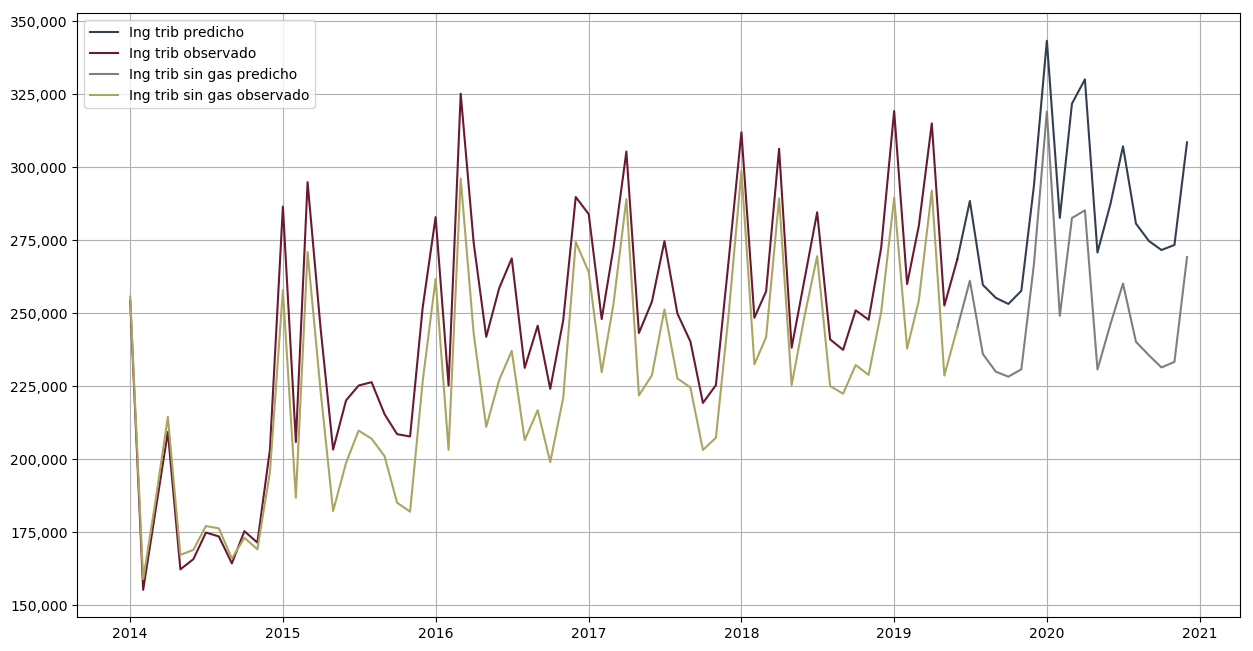

In [31]:
descriptive.plot_series(predictions_ing_trib,
                        ['arima_ing_trib_neto_(mdp)_r', 'ing_trib_neto_(mdp)_r',
                         'arima_ing_trib_sin_gasol_neto_(mdp)_r', 'ing_trib_sin_gasol_neto_(mdp)_r'], 
                         legend=['Ing trib predicho', 'Ing trib observado',
                                 'Ing trib sin gas predicho', 'Ing trib sin gas observado'], dpi=100,
                        min_date='2014-01-01',
                       save_to='../reporte/figures/pred_ing_trib.png')

In [32]:
predictions_isr_trib = predictions[['arima_isr_neto_(mdp)_r', 'var_isr_neto_(mdp)_r']].copy()
predictions_isr_trib['isr_neto_(mdp)_r']=predictions_isr_trib['arima_isr_neto_(mdp)_r']
predictions_isr_trib.loc['2019-07-01':, 'isr_neto_(mdp)_r'] = np.nan
predictions_isr_trib.loc[:'2019-05-01', ['arima_isr_neto_(mdp)_r', 'var_isr_neto_(mdp)_r']] = np.nan
##
predictions_iva_trib = predictions[['arima_iva_neto_(mdp)_r', 'ml_iva_neto_(mdp)_r']].copy()
predictions_iva_trib['iva_neto_(mdp)_r']=predictions_iva_trib['arima_iva_neto_(mdp)_r']
predictions_iva_trib.loc['2019-07-01':, 'iva_neto_(mdp)_r'] = np.nan
predictions_iva_trib.loc[:'2019-05-01', ['arima_iva_neto_(mdp)_r','ml_iva_neto_(mdp)_r']] = np.nan

In [33]:
predictions_isr_trib = pd.concat([predictions_isr_trib, predictions_iva_trib], axis=1)

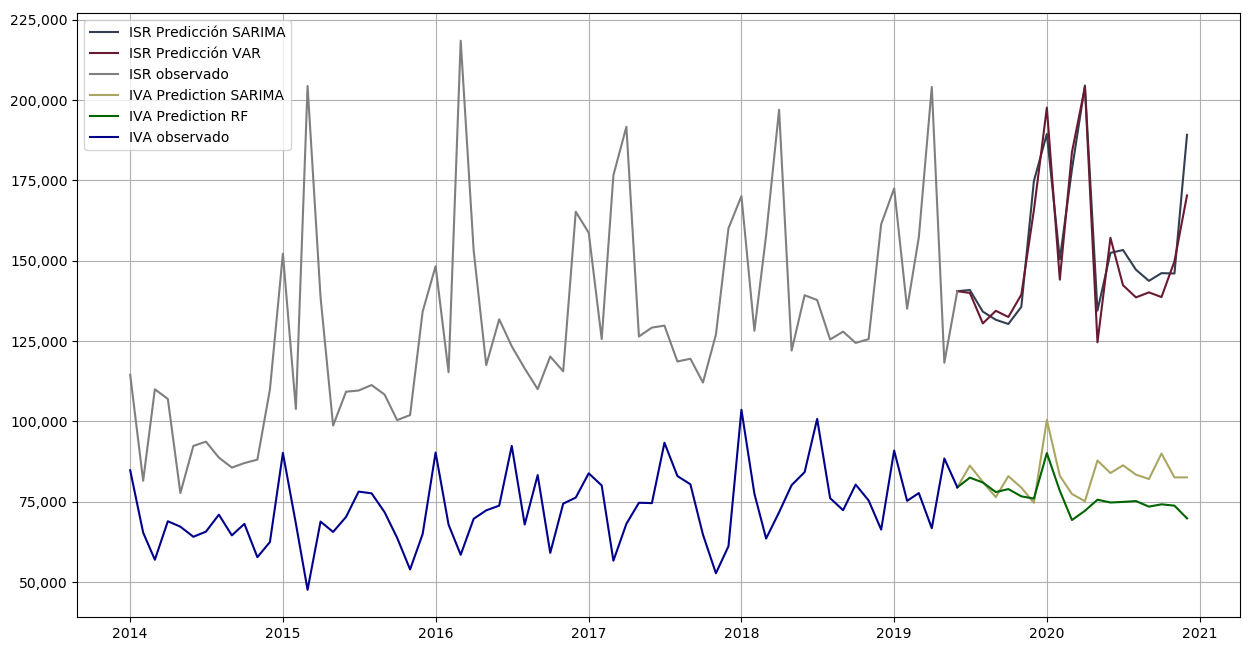

In [34]:
descriptive.plot_series(predictions_isr_trib,
                        ['arima_isr_neto_(mdp)_r', 'var_isr_neto_(mdp)_r', 'isr_neto_(mdp)_r',
                         'arima_iva_neto_(mdp)_r', 'ml_iva_neto_(mdp)_r', 'iva_neto_(mdp)_r'],
                        legend=['ISR Predicción SARIMA', 'ISR Predicción VAR', 'ISR observado',
                                'IVA Prediction SARIMA', 'IVA Prediction RF', 'IVA observado'], dpi=100,
                        min_date='2014-01-01',
                       save_to='../reporte/figures/pred_isr_iva.png')

In [35]:
predictions.columns

Index(['arima_ing_trib_neto_(mdp)_r', 'arima_ing_trib_sin_gasol_neto_(mdp)_r',
       'arima_isr_neto_(mdp)_r', 'var_isr_neto_(mdp)_r',
       'arima_iva_neto_(mdp)_r', 'ml_iva_neto_(mdp)_r',
       'ml_importaciones_neto_(mdp)_r', 'arima_ieps_sin_gas_neto_(mdp)_r',
       'var_ieps_sin_gas_neto_(mdp)_r'],
      dtype='object')

In [36]:
predictions_imp_trib = predictions[['ml_importaciones_neto_(mdp)_r']].copy()
predictions_imp_trib['imp_neto_(mdp)_r']=predictions_imp_trib['ml_importaciones_neto_(mdp)_r']
predictions_imp_trib.loc['2019-07-01':, 'imp_neto_(mdp)_r'] = np.nan
predictions_imp_trib.loc[:'2019-05-01', 'ml_importaciones_neto_(mdp)_r'] = np.nan
##
predictions_ieps_trib = predictions[['arima_ieps_sin_gas_neto_(mdp)_r', 'var_ieps_sin_gas_neto_(mdp)_r']].copy()
predictions_ieps_trib['ieps_sin_gas_neto_(mdp)_r']=predictions_ieps_trib['arima_ieps_sin_gas_neto_(mdp)_r']
predictions_ieps_trib.loc['2019-07-01':, 'ieps_sin_gas_neto_(mdp)_r'] = np.nan
predictions_ieps_trib.loc[:'2019-05-01', ['arima_ieps_sin_gas_neto_(mdp)_r', 'var_ieps_sin_gas_neto_(mdp)_r']] = np.nan

In [37]:
predictions_imp_trib = pd.concat([predictions_imp_trib, predictions_ieps_trib], axis=1)

In [38]:
predictions_imp_trib.columns

Index(['ml_importaciones_neto_(mdp)_r', 'imp_neto_(mdp)_r',
       'arima_ieps_sin_gas_neto_(mdp)_r', 'var_ieps_sin_gas_neto_(mdp)_r',
       'ieps_sin_gas_neto_(mdp)_r'],
      dtype='object')

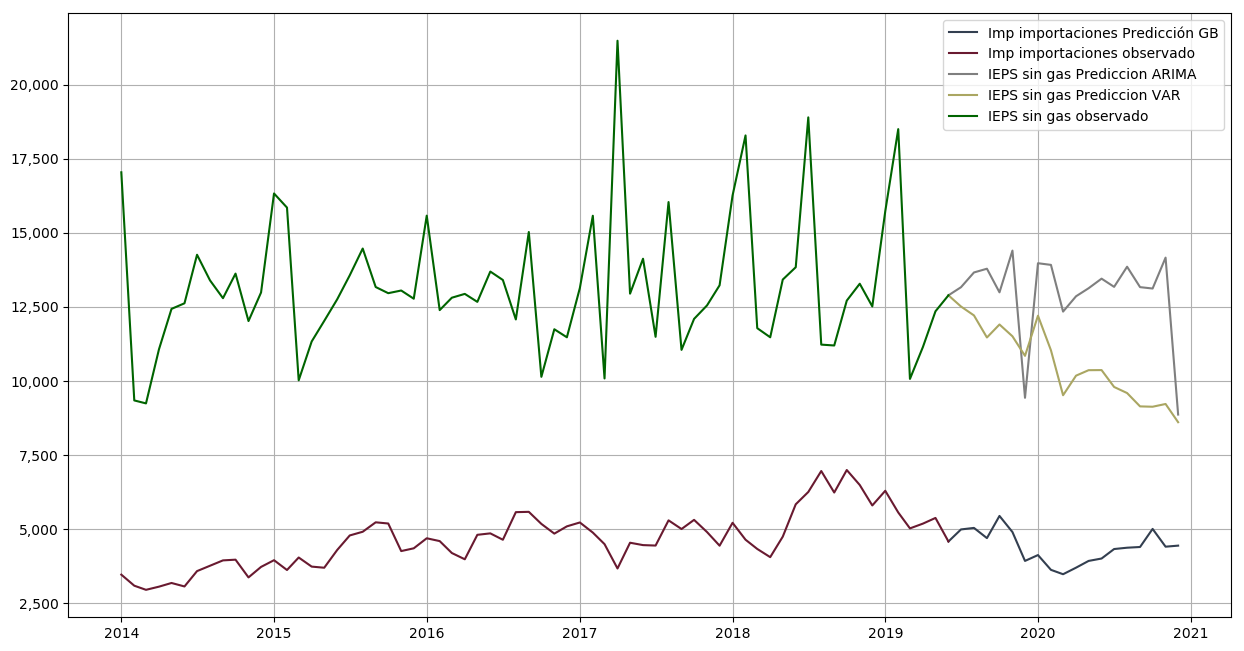

In [39]:
descriptive.plot_series(predictions_imp_trib,
                        ['ml_importaciones_neto_(mdp)_r', 'imp_neto_(mdp)_r',
                         'arima_ieps_sin_gas_neto_(mdp)_r', 'var_ieps_sin_gas_neto_(mdp)_r',
                         'ieps_sin_gas_neto_(mdp)_r'],
                        legend=['Imp importaciones Predicción GB', 'Imp importaciones observado',
                                'IEPS sin gas Prediccion ARIMA',
                                'IEPS sin gas Prediccion VAR', 'IEPS sin gas observado'], dpi=100,
                        min_date='2014-01-01',
                       save_to='../reporte/figures/pred_imp_ieps.png')

In [40]:
predictions.to_excel('../results/estimacion_mensual_cierre.xlsx', index=True)
predictions.resample('YS').sum().to_excel('../results/estimacion_anual.xlsx', index=Truee)

NameError: name 'Truee' is not defined

In [ ]:
predictions.resample('YS').sum().tail(2)